In [1]:
!pip3 install -Uqq conllu tabulate

import conllu

with open('dev.conllu', 'r') as file:
    corpus = conllu.parse(file.read())

ولم يكن من السهل عليه مواجهة كاميرات التلفزيون وعدسات المصورين وهو يصعد الباص . وقال بصوت خافت يكاد لا يسمع " الامر يخيفني بعض الشيء ( ... ) انها مفاجأة بالفعل . لن اكون متشردا بعد اليوم " .
وبعد ان ودع اصحابه وعناصر من الشرطة وابناء الحي الذي كان يبيت في شوارعه في العراء صعد الى الباص ليترك لونغ بيتش الواقعة على بعد ثلاثين كلم جنوب لوس انجليس بعد ان امضى فيها نحو عشرين عاما .
وقال " تلقينا الامر عند الساعة 22 ، 15 من يوم امس الجمعة بقصف الغابة حيث كان يوجد ، بحسب معلوماتنا ، لصوص " ( وهي التسمية التي يطلقها الروس في اشارة الى المقاتلين الشيشان ) .


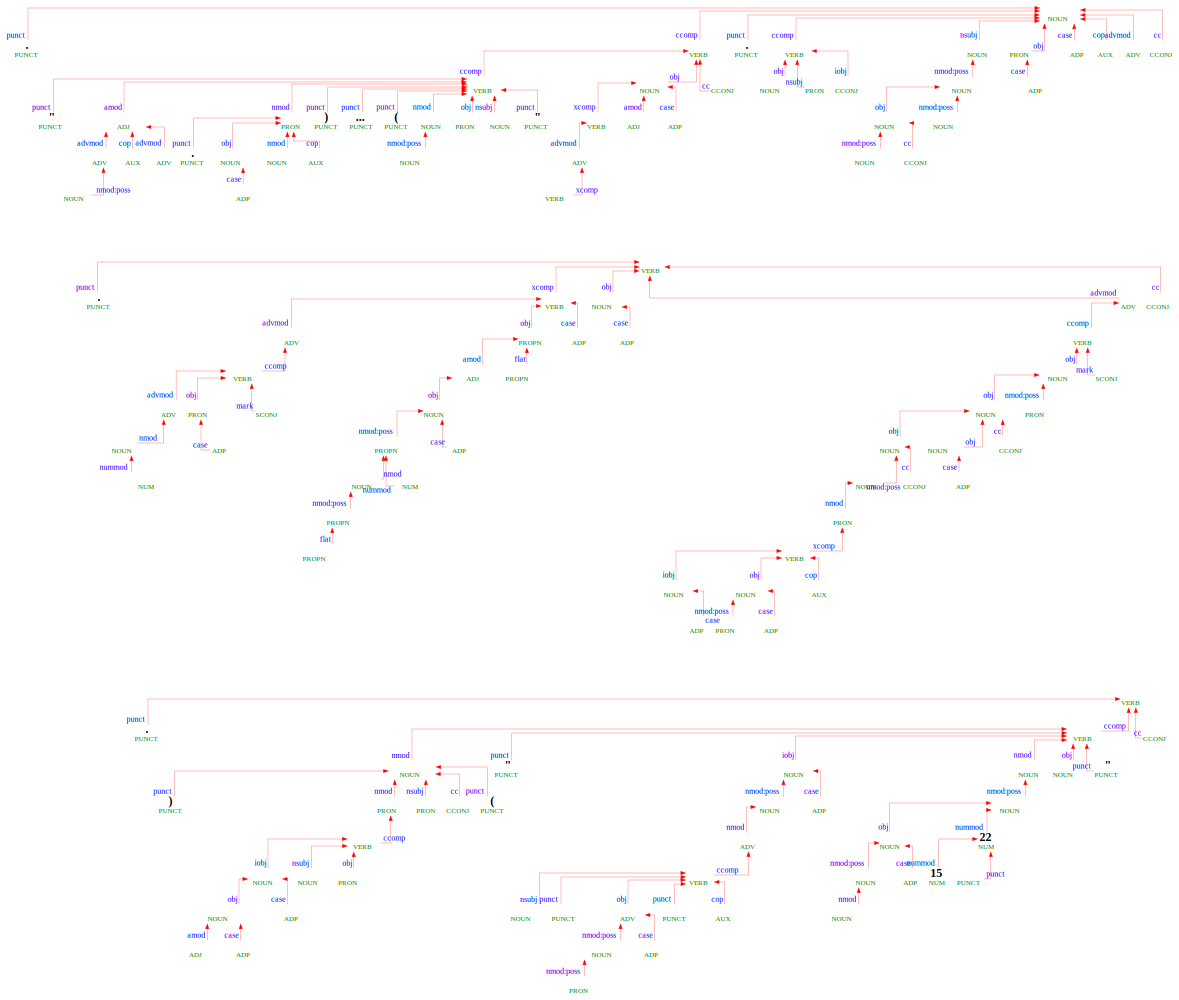

In [2]:
from graphviz import Digraph, nohtml

def _tree_draw(g, sent_id, node, depth):
    id_self = f"{sent_id}|{node.token['id']}"
    id_head = f"{sent_id}|{node.token['head']}"
    pos_x = -node.token['id'] / 3
    pos_y = -depth / 2
    g.node(
        id_self,
        label=f"<<b>{node.token}</b><br /><FONT POINT-SIZE='7' COLOR='green'>{node.token['upos']}</FONT>>",
        pos=f"{pos_x},{pos_y}!")
    if not id_head.endswith('|0'):
        g.edge(id_head, id_self, headlabel=node.token['deprel'])
    
    max_depth = depth
    for ch in node.children:
        max_depth = max(max_depth, _tree_draw(g, sent_id, ch, depth+1))
    return max_depth

def tree_draw(sentences):
    g = Digraph('G', engine="fdp",
                graph_attr={'splines': 'ortho', 'overlap': 'vpsc'},
                node_attr={'fontsize': '12', 'shape': 'plain'},
                edge_attr={'fontsize': '8', 'fontcolor': 'blue', 'color': 'red', 'arrowsize': '.5', 'dir': 'back', 'penwidth': '.25'})
    for sent in sentences:
        print(sent.metadata['text'])
    depth = 0
    for sent in sentences:
        sent_id = sent.metadata['sent_id'].replace(':', '#')
        with g.subgraph(name=sent_id) as c:
            depth = _tree_draw(c, sent_id, sent.to_tree(), depth) + 2
    return g

tree_draw([corpus[3], corpus[4], corpus[13]])

In [66]:
from copy import deepcopy

DEPREL2AR = {
  'ccomp': 'مفع',
  'nsubj': 'فاع',
  'obj': 'مف1',
  'iobj': 'مف2',
  'nmod': 'ظرف',
  'amod': 'صفة',
  'nmod:poss': 'إضف',
  'nummod': 'رقم',
  'cop': 'فعل',
}

def node_abs(node):
  node = conllu.TokenTree(deepcopy(node.token), deepcopy(node.children))
  node.token['abs'] = node.token['lemma'] if node.token['lemma'] != 'DEFAULT' else node.token['form']
  node.token['demo'] = node.token['form']
  if node.token['deprel'] == 'root':
    node.token['abs'] = f"[{node.token['upos']}]"
    node.token['demo'] = node.token['form']
  elif node.token['upos'] not in ['ADP', 'PART', 'PUNCT', 'SCONJ', 'CCONJ']:
    node.token['abs'] = f"<{node.token['deprel']}>"
    node.token['demo'] = f"<{DEPREL2AR[node.token['deprel']]}"
  return node

def tree_text(sent, key='abs'):
  return ' '.join([t.token[key] for t in sent])

def tree_abs(sent):
  if type(sent) is conllu.TokenList:
    sent = sent.to_tree()
  sent.token['deprel'] = 'root'
  flat_sent = list(map(node_abs, [sent] + sent.children))
  return sorted(flat_sent, key=lambda t: t.token['id'])

def tree_abs_recursive(sent):
  def _tree_abs_recursive(sent, output):
    abs_tree = tree_abs(sent)
    output.append(abs_tree)
    for t in abs_tree:
      if t.token['abs'].startswith('<'):
        _tree_abs_recursive(t, output)
    
  output = []
  _tree_abs_recursive(sent, output)
  return output

dbg_sent = corpus[13]
print(dbg_sent.metadata['text'])
for tree in tree_abs_recursive(dbg_sent):
  if len(tree) > 1:
    print(tree_text(tree, 'demo') + ' X ' + tree_text(tree, 'abs'))

وقال " تلقينا الامر عند الساعة 22 ، 15 من يوم امس الجمعة بقصف الغابة حيث كان يوجد ، بحسب معلوماتنا ، لصوص " ( وهي التسمية التي يطلقها الروس في اشارة الى المقاتلين الشيشان ) .
و قال <مفع . X w [VERB] <ccomp> .
" تلقينا <مف1 <ظرف <مف2 " <ظرف X " [VERB] <obj> <nmod> <iobj> " <nmod>
عند <إضف X [NOUN] <nmod:poss>
الساعة <رقم <مف1 X [NOUN] <nummod> <obj>
22 ، <رقم X [NUM] ، <nummod>
من يوم <إضف X min_1 [NOUN] <nmod:poss>
امس <ظرف X [NOUN] <nmod>
ب قصف <إضف X b [NOUN] <nmod:poss>
الغابة <ظرف X [NOUN] <nmod>
حيث <مفع X [ADV] <ccomp>
<فعل يوجد ، <مف1 ، <فاع X <cop> [VERB] ، <obj> ، <nsubj>
ب حسب <إضف X b [ADV] <nmod:poss>
معلومات <إضف X [NOUN] <nmod:poss>
( و <فاع التسمية <ظرف ) X ( w <nsubj> [NOUN] <nmod> )
التي <مفع X [PRON] <ccomp>
يطلق <مف1 <فاع <مف2 X [VERB] <obj> <nsubj> <iobj>
في اشارة <مف1 X fiy_1 [NOUN] <obj>
الى المقاتلين <صفة X <ilaY_1 [NOUN] <amod>
